# 分析ノート

In [1]:
from IPython.display import Image, display_png
import pickle
from matplotlib.colors import LinearSegmentedColormap

import analyze_strength

def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
        
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

# 前処理

In [2]:
%time !python preprocess.py > /dev/null

CPU times: user 70 ms, sys: 30 ms, total: 100 ms
Wall time: 3.4 s


# 分析

## プロテニスプレイヤーの強さのモデル

In [5]:
%time !python analyze_strength.py > /dev/null

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8bc3da4da00965b5451a30c45bbfb557 NOW.
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 15)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 15)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



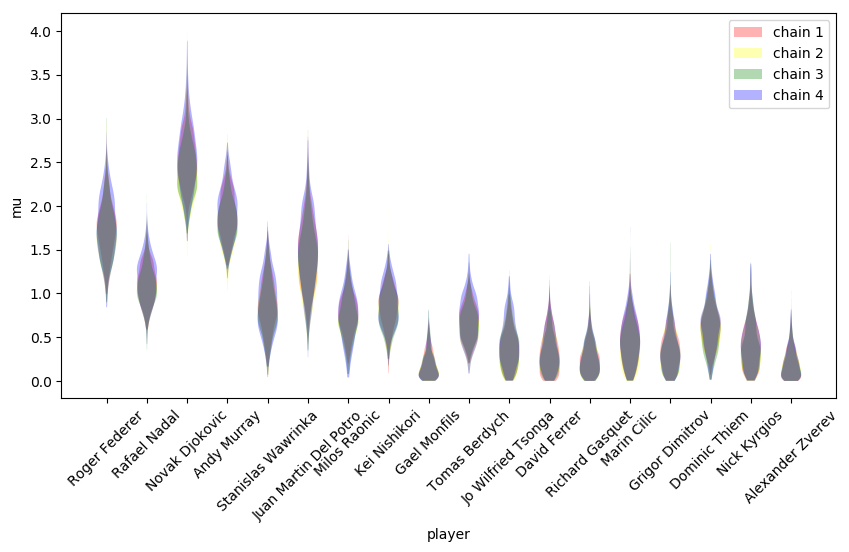

In [6]:
display_png(Image('./graphs/strength_mu_chains.png'))

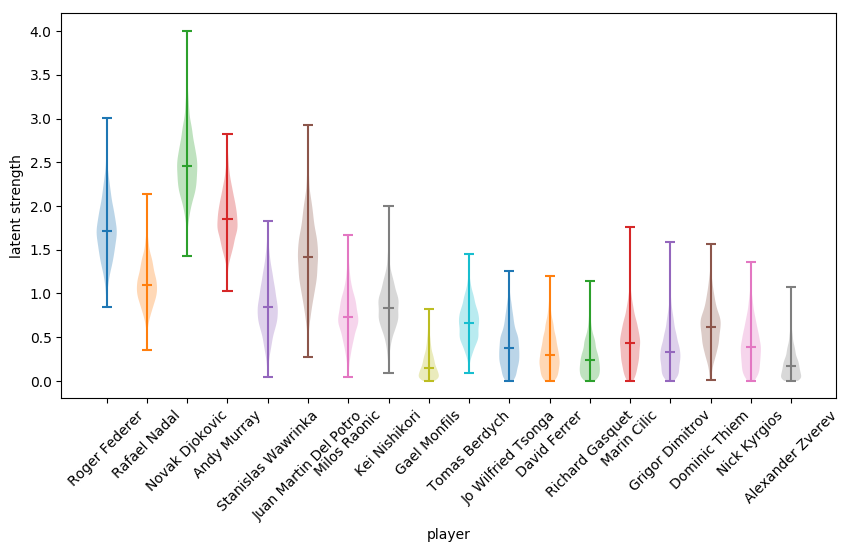

In [7]:
display_png(Image('./graphs/strength_mu.png'))

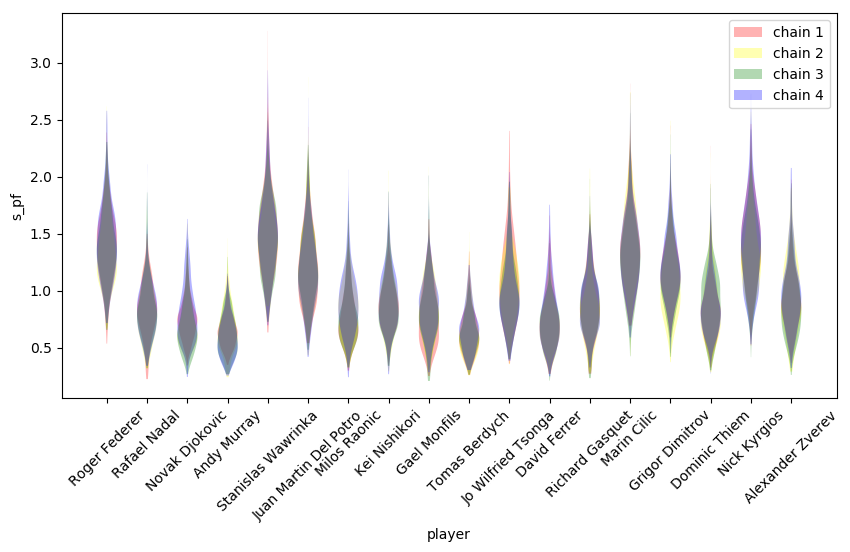

In [8]:
display_png(Image('./graphs/strength_s_pf_chains.png'))

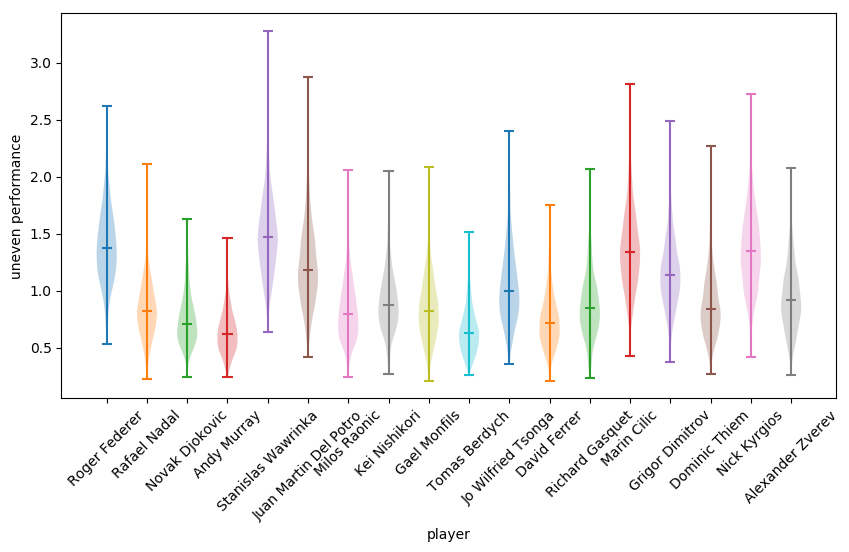

In [9]:
display_png(Image('./graphs/strength_s_pf.png'))

## プロテニスプレイヤーの時系列で見た強さのモデル

In [10]:
#!python analyze_strength_ts.py

In [3]:
import numpy as np                                                                                                                                                                                                                                                                
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import pystan
#import imgkit
import pickle

In [4]:
arr_target_player = np.array([
    'Roger Federer', 'Rafael Nadal', 'Novak Djokovic',
    'Andy Murray', 'Stanislas Wawrinka', 'Juan Martin Del Potro',
    'Kei Nishikori', 'Tomas Berdych', 'David Ferrer'
])

In [5]:
arr_target_year = np.array(list(range(2005, 2017))) # 2005--2016

In [6]:
df_matches = pd.read_csv('./df_matches.csv')

In [7]:
df_target = df_matches[
    (df_matches['date'] < '2017-03') 
]

In [8]:
dic_target_year = {}

for year in arr_target_year:
    if year not in dic_target_year:
        dic_target_year[year] = len(dic_target_year)+1

In [9]:
dic_target_player = {}

for player in arr_target_player:
    if player not in dic_target_player:
        dic_target_player[player] = len(dic_target_player)+1

In [10]:
LW = []
GY = []

for year in arr_target_year:
    for player_a in arr_target_player:
        for player_b in arr_target_player:
            
            df_tmp = df_target[
                (df_target['winner_name'] == player_a) &
                (df_target['loser_name'] == player_b)
            ]
            
            for _ in range(len(df_tmp)):
                
                LW.append([dic_target_player[player_b], dic_target_player[player_a]])
                GY.append(dic_target_year[year])
                
            df_tmp = df_target[
                (df_target['winner_name'] == player_b) &
                (df_target['loser_name'] == player_a)
            ]
            
            for _ in range(len(df_tmp)):
                
                LW.append([dic_target_player[player_a], dic_target_player[player_b]])
                GY.append(dic_target_year[year])

LW = np.array(LW, dtype=np.int32)
GY = np.array(GY, dtype=np.int32)

In [11]:
model = ''
with open('./model_strength_ts.stan') as f:
    model = f.read()

In [12]:
data = {
    'N': len(dic_target_player),
    'G': len(LW),
    'Y': len(dic_target_year),
    'GY': GY,
    'LW': LW,
}
fit = pystan.stan(model_code=model, data=data, iter=5000, chains=4)
la = fit.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fde0244bca0f1943eefeff1ca69001b0 NOW.


KeyboardInterrupt: 

In [11]:
model = """
    data {
        int N;
        int G;
        int Y;
        int<lower=1> GY[G];
        int<lower=1, upper=N> LW[G, 2];
    }
    parameters {
        ordered[2] performance[G];
        matrix<lower=0>[N, Y] mu;
        matrix<lower=0>[N, Y] s_mu;
        matrix<lower=0>[N, Y] s_pf;
    }
    model {
        for (g in 1:G)
            for (i in 1:2)
                performance[g, i] ~ normal(mu[LW[g, i], GY[g]], s_pf[LW[g, i], GY[g]]);
        
        for (n in 1:N)
            mu[n, 1] ~ normal(0, s_mu[n, 1]);
            
        for (n in 1:N)
            for (y in 2:Y)
                mu[n, y] ~ normal(mu[n, y-1], s_mu[n, y]);
           
        for (n in 1:N)
            s_mu[n] ~ normal(0, 1);
        
        for (n in 1:N)
            s_pf[n] ~ gamma(10, 10);
    }
"""
data = {
    'N': len(dic_target_player),
    'G': len(LW),
    'Y': len(dic_target_year),
    'GY': GY,
    'LW': LW,
}
fit2 = pystan.stan(model_code=model, data=data, iter=5000, chains=4)
la2 = fit2.extract()
fit2

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3c1718846b89aba379205c16add9d7f3 NOW.
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwa

KeyboardInterrupt: 